In [1]:
import numpy as np
import json
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from tqdm.notebook import tqdm
from scipy.optimize import minimize, Bounds

In [2]:
import wrapper # загружаем солвер

In [3]:
def make_answer(xc, yc, labels):
    #сформируем ответ по координатам кустовых площадок
    a = wrapper.Answer()
    #присваеваем каждую скважину кустовой площадке (задаем имя скважины и координаты центра кустовой площадки)
    for well_index, well_pad_id in enumerate(labels):
        a.add_single_well(xc[well_pad_id], yc[well_pad_id], nameWell[well_index])
    #экспортируем ответ в формат json
    return a.export

In [25]:
#оптимизация методом симуляции отжига
def simulated_annealing(f, x_init, n=100, temperature=lambda x: 1/np.log(x + 2), 
                        variance=lambda x: 1000/np.log(x + 2)):
    x = x_best = x_init
    cur_f = best_f = f(x_init)
    for i in tqdm(range(n)):
        x_new = x + st.multivariate_normal(np.zeros(x.shape[0]), variance(i)*np.eye(x.shape[0])).rvs()
        new_f = f(x_new)
        if new_f < cur_f or st.uniform().rvs() < np.exp((cur_f - new_f)*temperature(i)):
            x, cur_f = x_new, new_f
            if best_f > cur_f:
                x_best = x
                best_f = cur_f
    return x_best, best_f

In [26]:
class WellPads:
    def __init__(self, info_path):
        self.load_data(info_path)
        self.build_pads()
        
    def load_data(self, info_path):
        with open(info_path) as info_f:
            info = json.load(info_f)
        self.CONST_ALPHA = info["CONST"]["CALPHA"] # минимальная длина ребра кустовой площадки
        # тыс.руб
        self.CONST_C0 = info["CONST"]["C0"] # стоимость монтажа бурвой площадки
        self.CONST_C1 = info["CONST"]["C1"] # стоимость демонтажа бурвой площадки
        self.CONST_C2 = info["CONST"]["C2"] #стоимость переезда буровой на одной кустовой площадке
        # тыс.руб/м
        self.CONST_C3 = info["CONST"]["C3"] #стоимость бурения 1 м
        self.CONST_L = info["CONST"]["CL"] # максимальная длина скважины
        self.CONST_D = info["CONST"]["CD"] # между скважинами
        self.CONST_PENALTY = info["CONST"]["CPENALTY"] # мнодитель штрафа за недопустимые действиея
        self.map_path = info["FILES"]["map"] # карта стоимостей
        self.wells_path = info["FILES"]["wells"] # датасет геологических целей
        #Загружаем датасет
        self.dem_df = pd.read_csv(self.map_path, sep="\t")
        self.wells_df = pd.read_csv(self.wells_path, sep=';')
        #Парсим датасет
        self.nameWell, self.timeWell, self.x1Well, self.y1Well, self.z1Well, \
            self.x3Well, self.y3Well, self.z3Well, = wrapper.loadWells(self.wells_df)
        self.xDem, self.yDem, self.costDem = wrapper.loadDEM(self.dem_df)
        
    #напишем функции, которая позволит преобразовывать вектор координат x в координаты кустов скважин
    def solve(self, x, labels):
        a = wrapper.Answer()
        for well_index, well_pad_id in enumerate(labels):
            a.add_single_well(x[2*well_pad_id], x[2*well_pad_id+1], self.nameWell[well_index])
    
        answer_json = a.export
    
        solution = wrapper.Solution(self.dem_df, self.wells_df, answer_json, self.CONST_ALPHA, 
                                    self.CONST_C0, self.CONST_C1, self.CONST_C2, 
                                    self.CONST_C3, self.CONST_L, self.CONST_D, self.CONST_PENALTY)
        return solution    
        
    def build_pads(self):
        self.X = np.zeros((len(self.x1Well),3))
        self.X[:,0] = self.x1Well
        self.X[:,1] = self.y1Well
        self.X[:,2] = self.z1Well
        k = 1
        stop = False
        self.best = np.inf
        while not stop:
            stop = True
            #вычисляем координаты центров кластеров
            kmeans = KMeans(n_clusters=k).fit(self.X)
            for num, cc in enumerate(kmeans.cluster_centers_):
                dist = np.linalg.norm(self.X[kmeans.labels_ == num] - cc, axis=1)
                if not np.all(dist < self.CONST_L):
                    stop = False
                    break
            if stop: 
                # начальная догадка для вектора варьируемых параметров (координат центров)
                x_init = np.array([item for sublist in kmeans.cluster_centers_[:,0:2] for item in sublist])
                x_new, cost = simulated_annealing(lambda x: self.solve(x, kmeans.labels_).cost, x_init)
                print(k, cost)
                if cost < self.best:
                    self.best = cost
                    stop = False
                    self.labels = kmeans.labels_
                    self.x = x_new
            k = k + 1
        self.solution = self.solve(self.x, self.labels)
        
    def plot_pads(self):
        plt.scatter(self.X[:,0],self.X[:,1], label='wells T1')
        plt.scatter(self.x[::2], self.x[1::2], c='r', label='well pads')
        plt.legend()
        plt.show()

In [27]:
test = WellPads('info_test.json')

  0%|          | 0/100 [00:00<?, ?it/s]

4 1906791.004455145


  0%|          | 0/100 [00:00<?, ?it/s]

5 1822469.7464720162


  0%|          | 0/100 [00:00<?, ?it/s]

6 1792820.318407647


  0%|          | 0/100 [00:00<?, ?it/s]

7 1765997.6054113174


  0%|          | 0/100 [00:00<?, ?it/s]

8 1739806.7313884154


  0%|          | 0/100 [00:00<?, ?it/s]

9 1730411.193331018


  0%|          | 0/100 [00:00<?, ?it/s]

10 1724385.0512560362


  0%|          | 0/100 [00:00<?, ?it/s]

11 1724178.8950537585


  0%|          | 0/100 [00:00<?, ?it/s]

12 1724226.5186967596


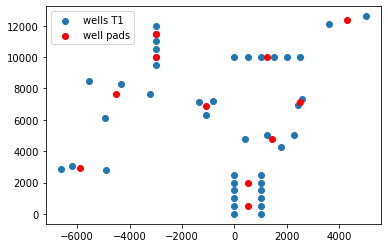

In [28]:
test.plot_pads()

In [29]:
test.solution.cost

1724178.8950537585

In [30]:
print(test.solution.log)

wellPad K = 1.0
wellPad K = 1.0
wellPad K = 1.0
wellPad K = 1.0
wellPad K = 1.0
wellPad K = 1.0
wellPad K = 1.0
wellPad K = 1.0
wellPad K = 1.0
wellPad K = 1.0
wellPad K = 1.0
2022-12-12 00:00:00 - start drilling wells at Well Pad 0, cost += 4000.0, cost = 4.00e+03 
2022-12-12 00:00:00 - done  drilling well 1 at Well Pad 0, cost += 37620.46342840757, cost = 4.16e+04 
2022-12-12 00:00:00 - move  drilling well 2 at Well Pad 0, cost += 200.0, cost = 4.18e+04 
2022-12-12 00:00:00 - done  drilling well 2 at Well Pad 0, cost += 37164.130760987, cost = 7.90e+04 
2022-12-12 00:00:00 - move  drilling well 3 at Well Pad 0, cost += 200.0, cost = 7.92e+04 
2022-12-12 00:00:00 - done  drilling well 3 at Well Pad 0, cost += 37620.463428407566, cost = 1.17e+05 
2022-12-12 00:00:00 - move  drilling well 7 at Well Pad 0, cost += 200.0, cost = 1.17e+05 
2022-12-12 00:00:00 - done  drilling well 7 at Well Pad 0, cost += 37620.46342840757, cost = 1.55e+05 
2022-12-12 00:00:00 - move  drilling well 8 at We

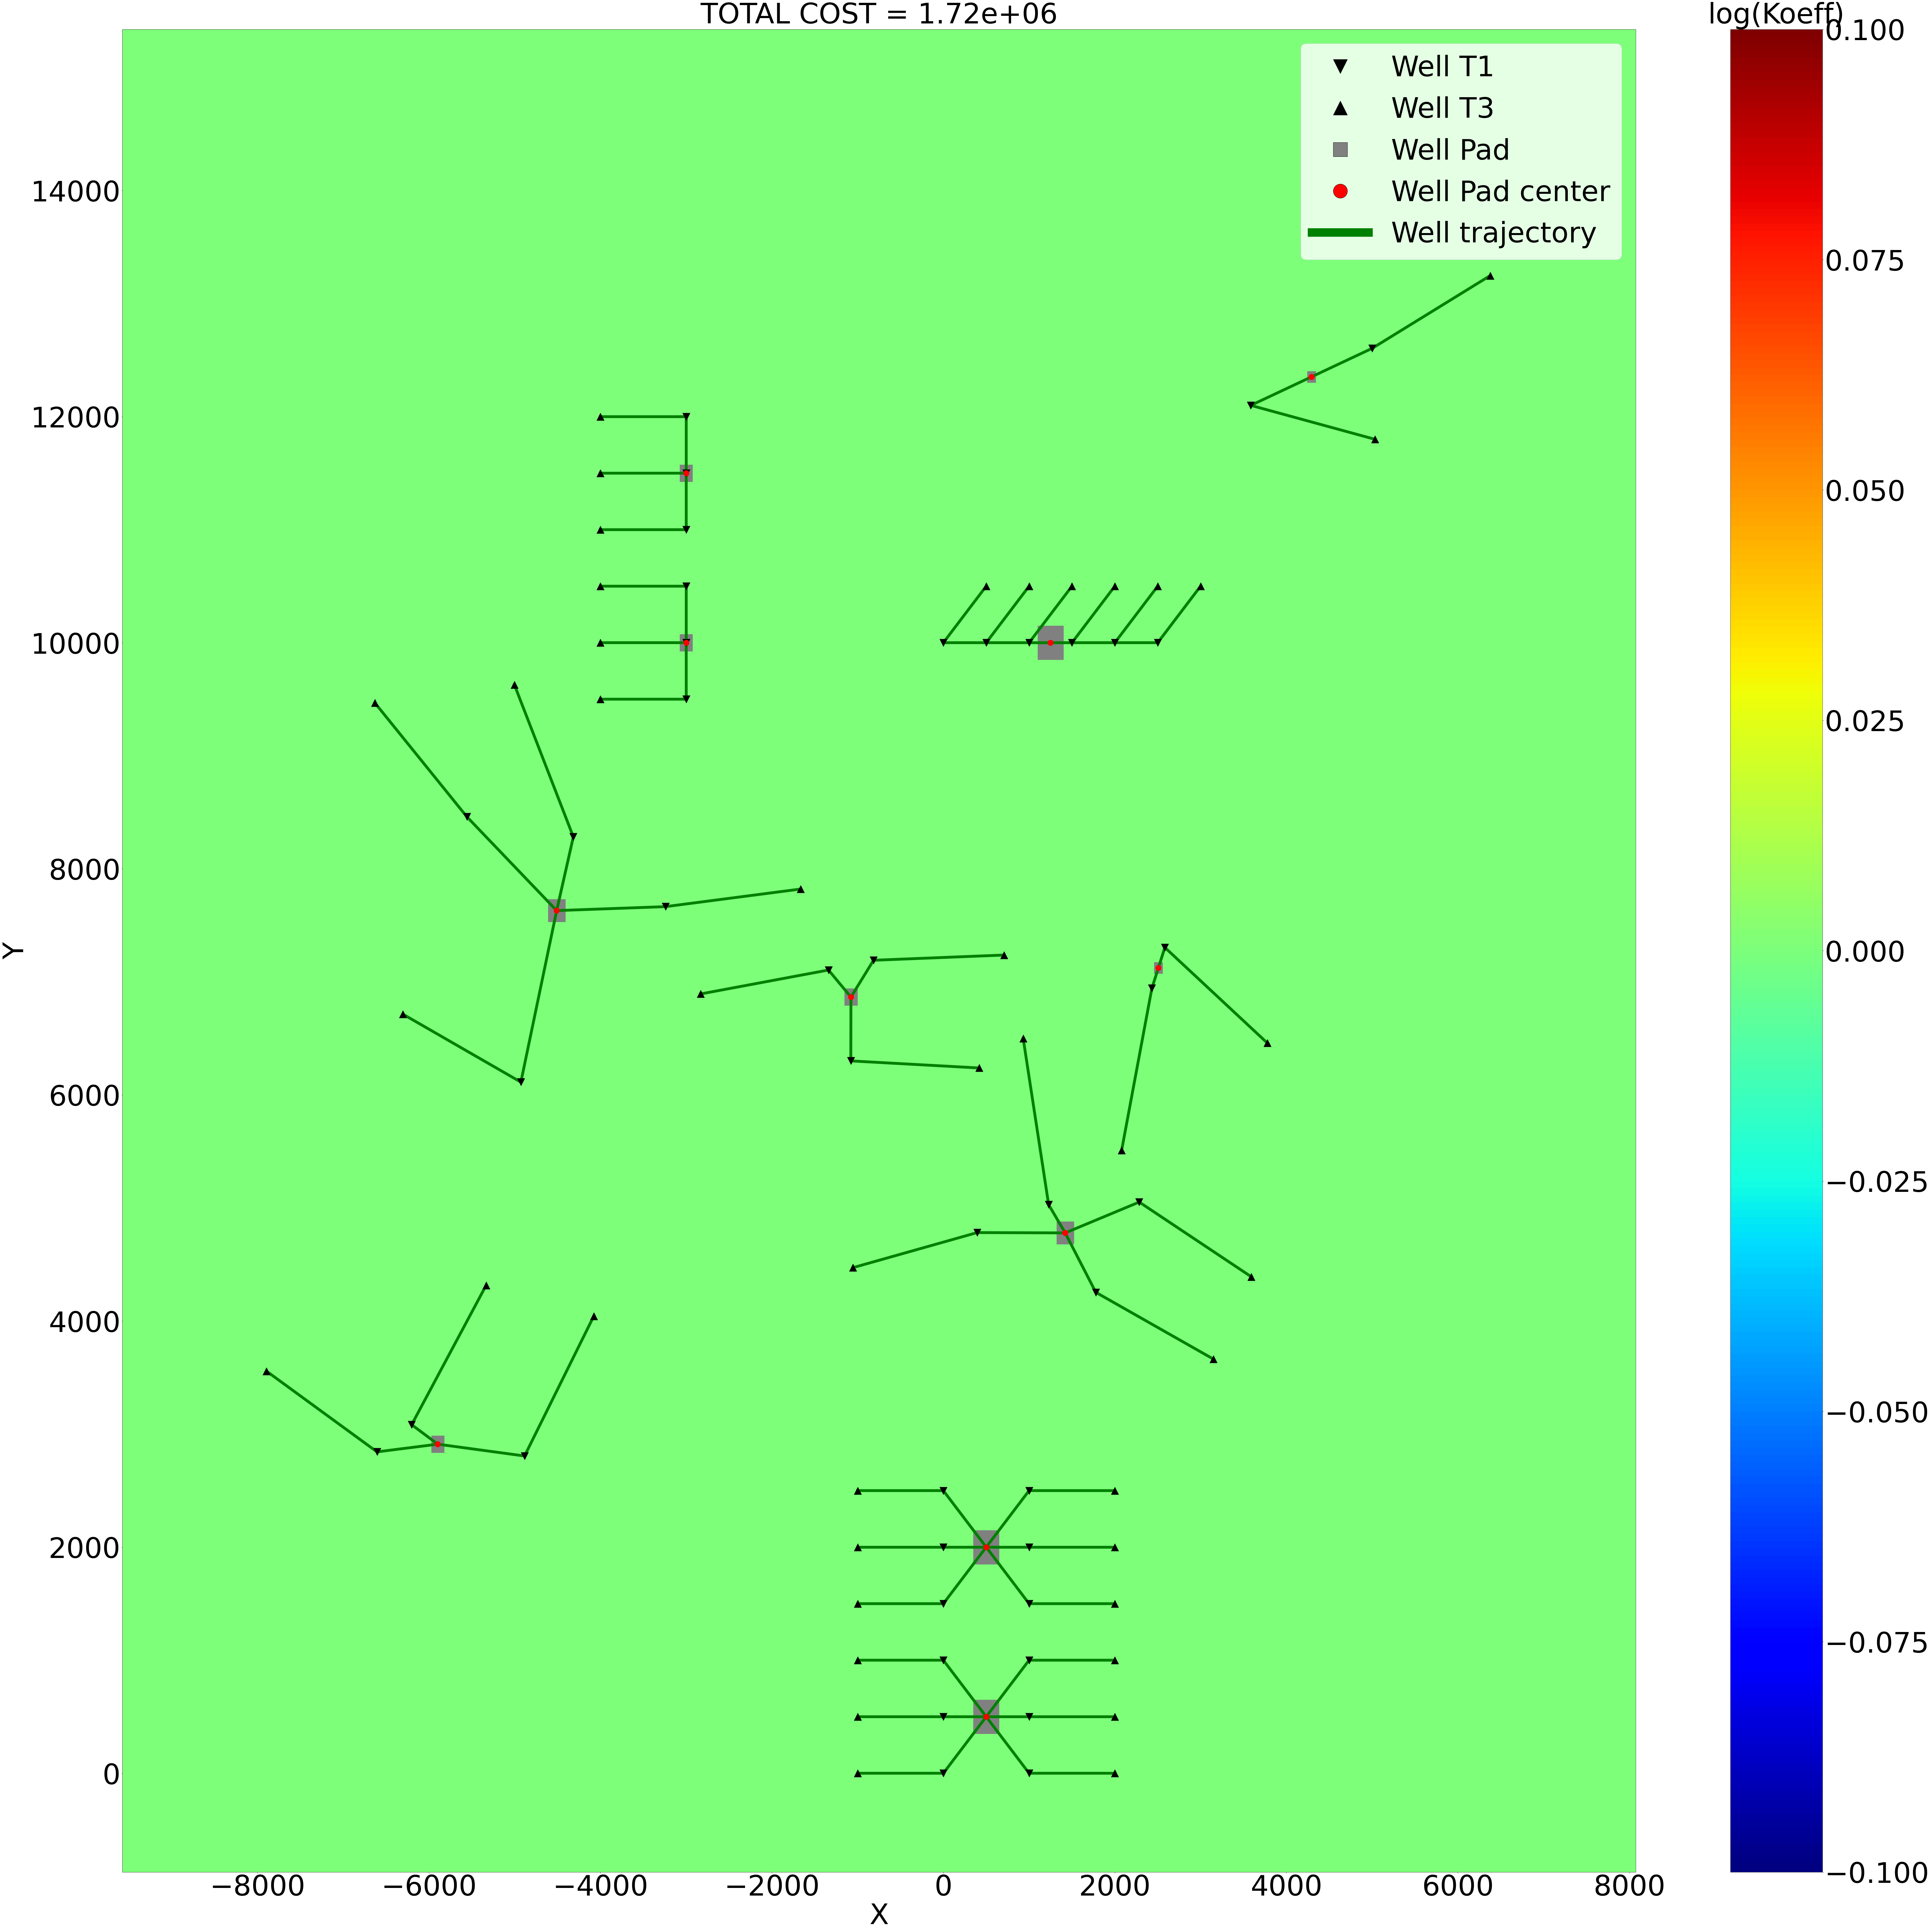

In [31]:
test.solution.plot()

In [32]:
case1 = WellPads('info_case1.json')

  0%|          | 0/100 [00:00<?, ?it/s]

1 3166677.1910750982


  0%|          | 0/100 [00:00<?, ?it/s]

2 2650858.411729077


  0%|          | 0/100 [00:00<?, ?it/s]

3 2430689.4966687015


  0%|          | 0/100 [00:00<?, ?it/s]

4 2330038.866062262


  0%|          | 0/100 [00:00<?, ?it/s]

5 2269379.917873254


  0%|          | 0/100 [00:00<?, ?it/s]

6 2207918.6572572337


  0%|          | 0/100 [00:00<?, ?it/s]

7 2281134.9860941013


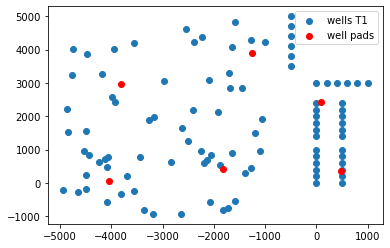

In [33]:
case1.plot_pads()

In [34]:
case1.solution.cost

2207918.6572572337

In [35]:
print(case1.solution.log)

wellPad K = 1.0
wellPad K = 2.0
wellPad K = 1.0
wellPad K = 1.0
wellPad K = 1.0
wellPad K = 1.0
2021-12-12 00:00:00 - start drilling wells at Well Pad 0, cost += 4000.0, cost = 4.00e+03 
2021-12-12 00:00:00 - done  drilling well 1 at Well Pad 0, cost += 22084.426958491094, cost = 2.61e+04 
2021-12-12 00:00:00 - move  drilling well 2 at Well Pad 0, cost += 200.0, cost = 2.63e+04 
2021-12-12 00:00:00 - done  drilling well 2 at Well Pad 0, cost += 21772.982091120357, cost = 4.81e+04 
2021-12-12 00:00:00 - move  drilling well 3 at Well Pad 0, cost += 200.0, cost = 4.83e+04 
2021-12-12 00:00:00 - done  drilling well 3 at Well Pad 0, cost += 21696.95217571371, cost = 7.00e+04 
2021-12-12 00:00:00 - move  drilling well 4 at Well Pad 0, cost += 200.0, cost = 7.02e+04 
2021-12-12 00:00:00 - done  drilling well 4 at Well Pad 0, cost += 21859.522403884926, cost = 9.20e+04 
2021-12-12 00:00:00 - move  drilling well 5 at Well Pad 0, cost += 200.0, cost = 9.22e+04 
2021-12-12 00:00:00 - done  drilli

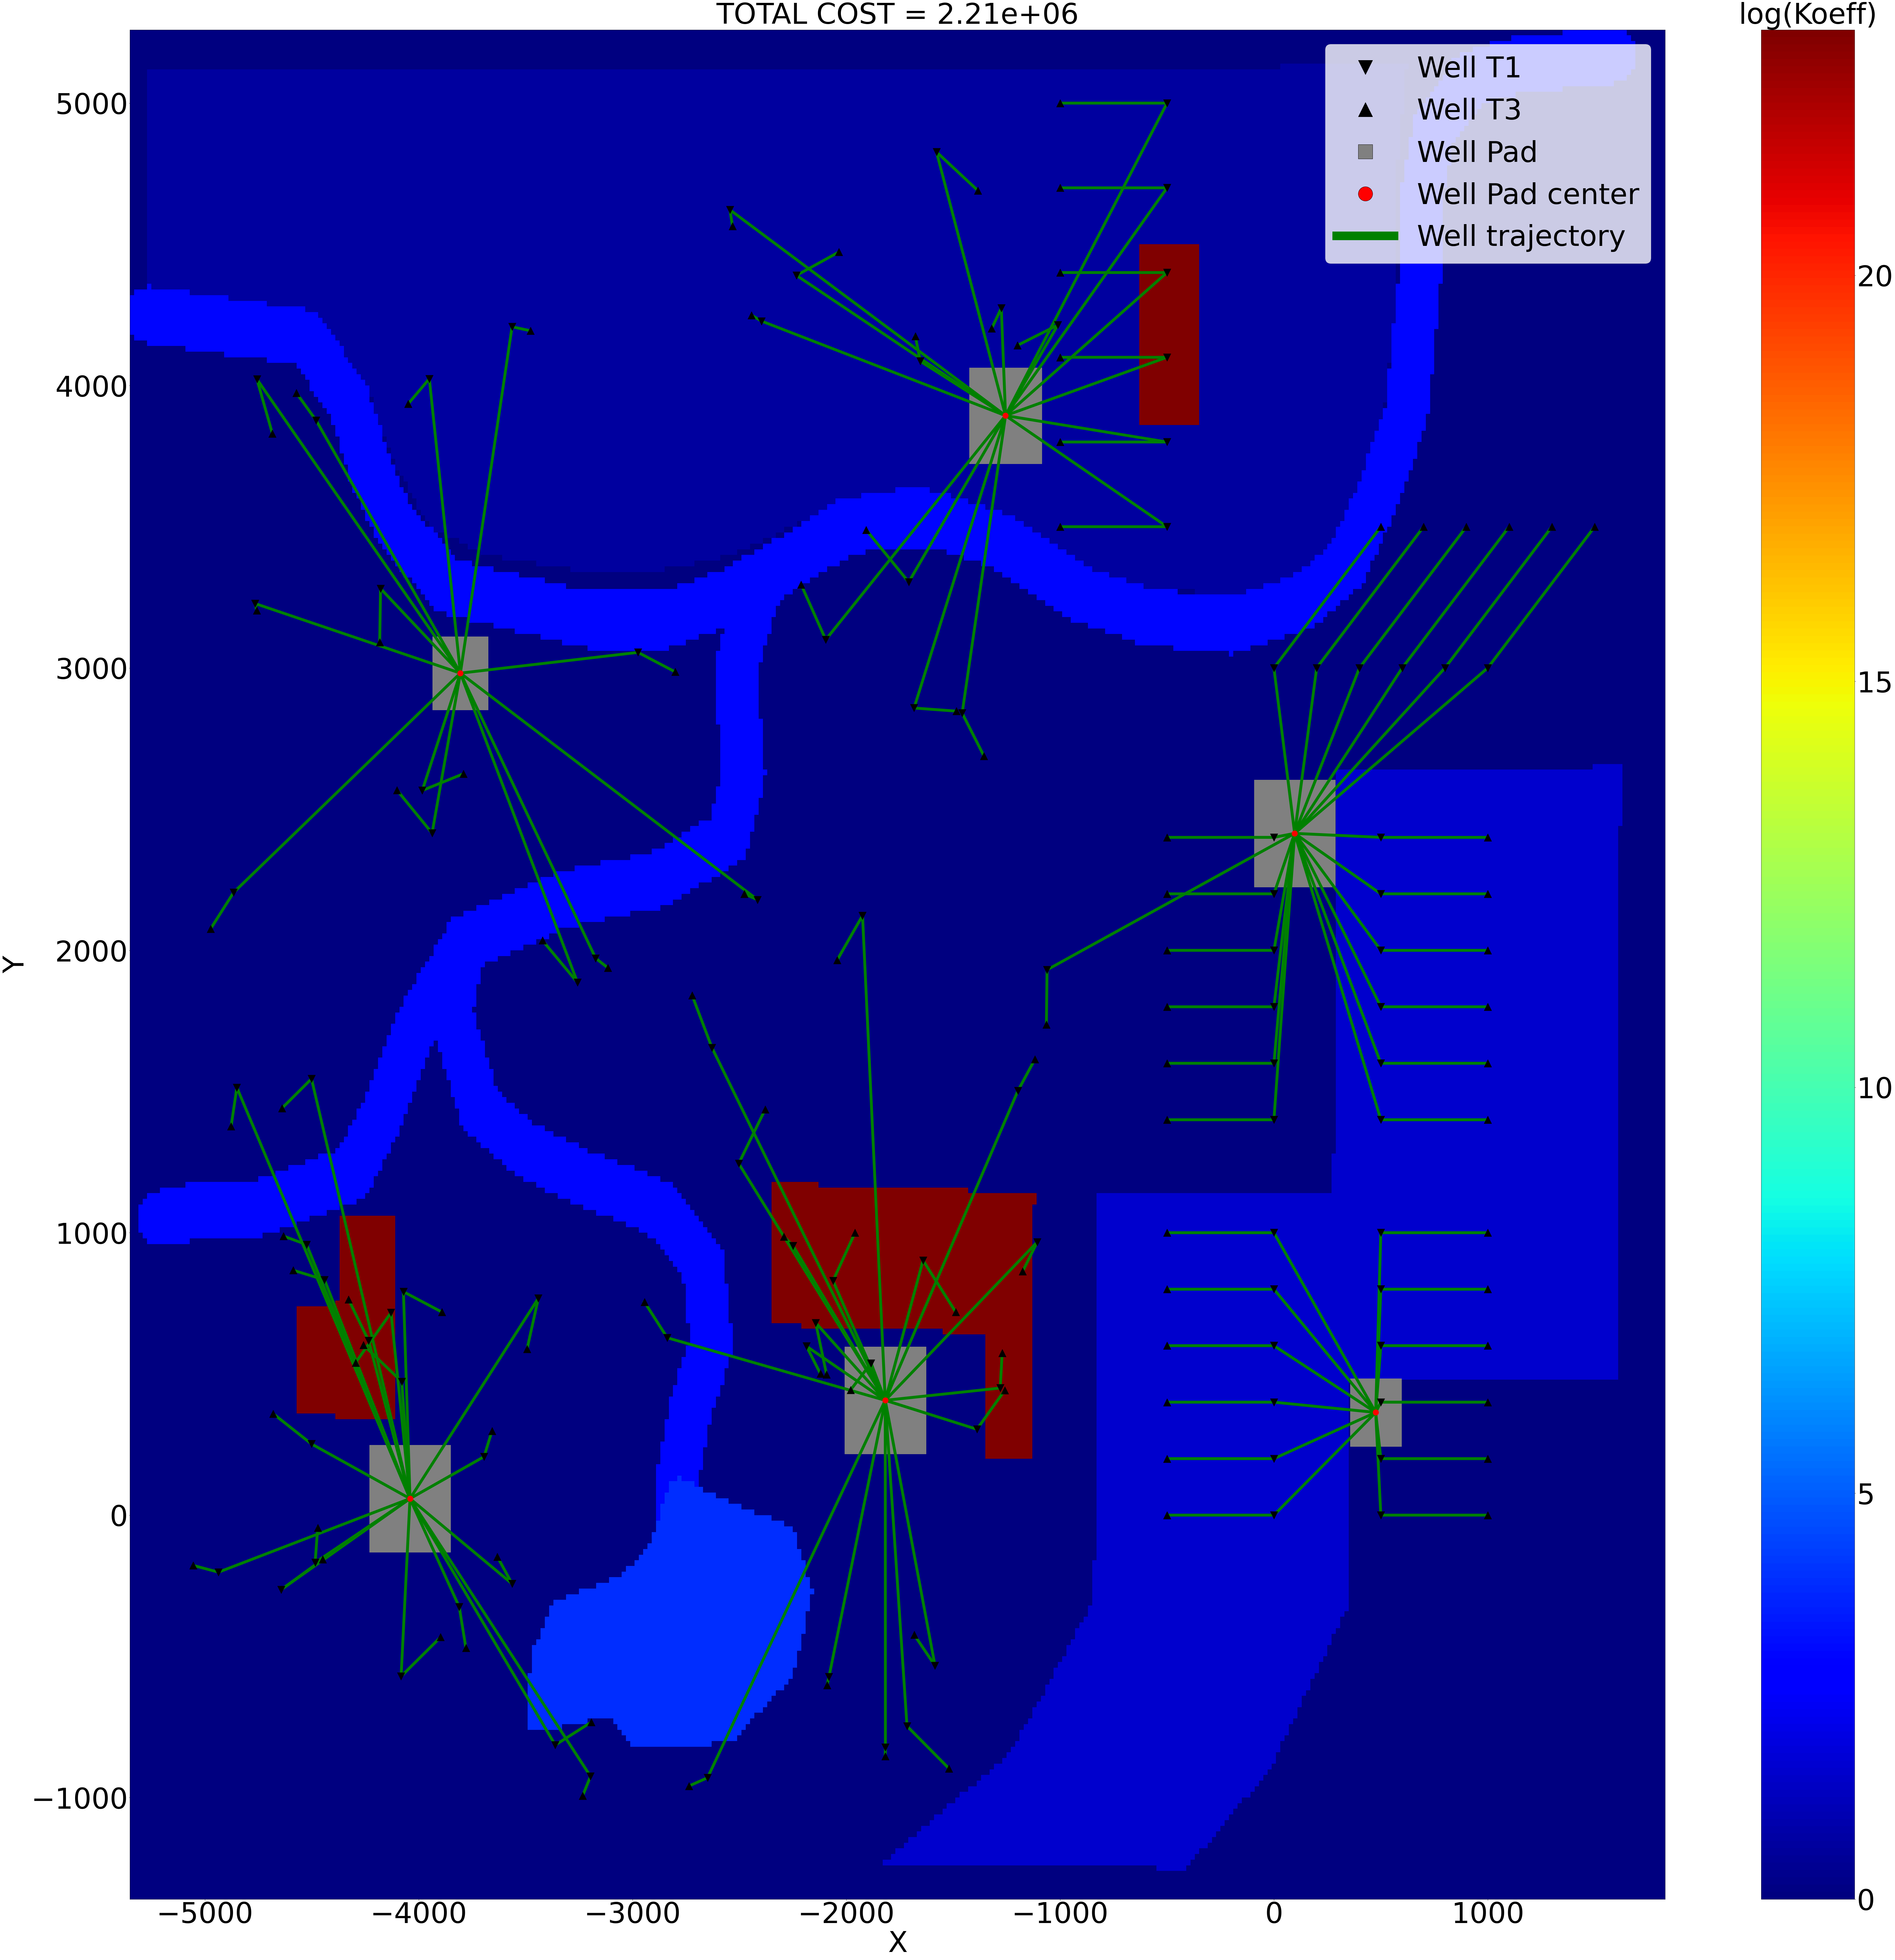

In [36]:
case1.solution.plot()

In [37]:
case2 = WellPads('info_case2.json')

  0%|          | 0/100 [00:00<?, ?it/s]

2 77287710282061.9


  0%|          | 0/100 [00:00<?, ?it/s]

3 6612437.181609892


  0%|          | 0/100 [00:00<?, ?it/s]

4 61673802335779.3


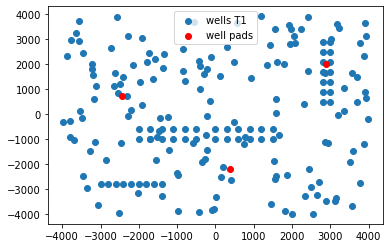

In [38]:
case2.plot_pads()

In [39]:
case2.solution.cost

6612437.181609892

In [40]:
print(case2.solution.log)

wellPad K = 7.361212563915267
wellPad K = 1.9567474048442905
wellPad K = 10.38625845496618
2021-12-12 00:00:00 - start drilling wells at Well Pad 0, cost += 29444.850255661066, cost = 2.94e+04 
2021-12-12 00:00:00 - done  drilling well 1 at Well Pad 0, cost += 32594.11177226406, cost = 6.20e+04 
2021-12-12 00:00:00 - move  drilling well 5 at Well Pad 0, cost += 1472.2425127830534, cost = 6.35e+04 
2021-12-12 00:00:00 - done  drilling well 5 at Well Pad 0, cost += 27075.97833300793, cost = 9.06e+04 
2021-12-12 00:00:00 - move  drilling well 11 at Well Pad 0, cost += 1472.2425127830534, cost = 9.21e+04 
2021-12-12 00:00:00 - done  drilling well 11 at Well Pad 0, cost += 30180.52365593306, cost = 1.22e+05 
2021-12-12 00:00:00 - move  drilling well 13 at Well Pad 0, cost += 1472.2425127830534, cost = 1.24e+05 
2021-12-12 00:00:00 - done  drilling well 13 at Well Pad 0, cost += 32558.755331005817, cost = 1.56e+05 
2021-12-12 00:00:00 - move  drilling well 21 at Well Pad 0, cost += 1472.2425

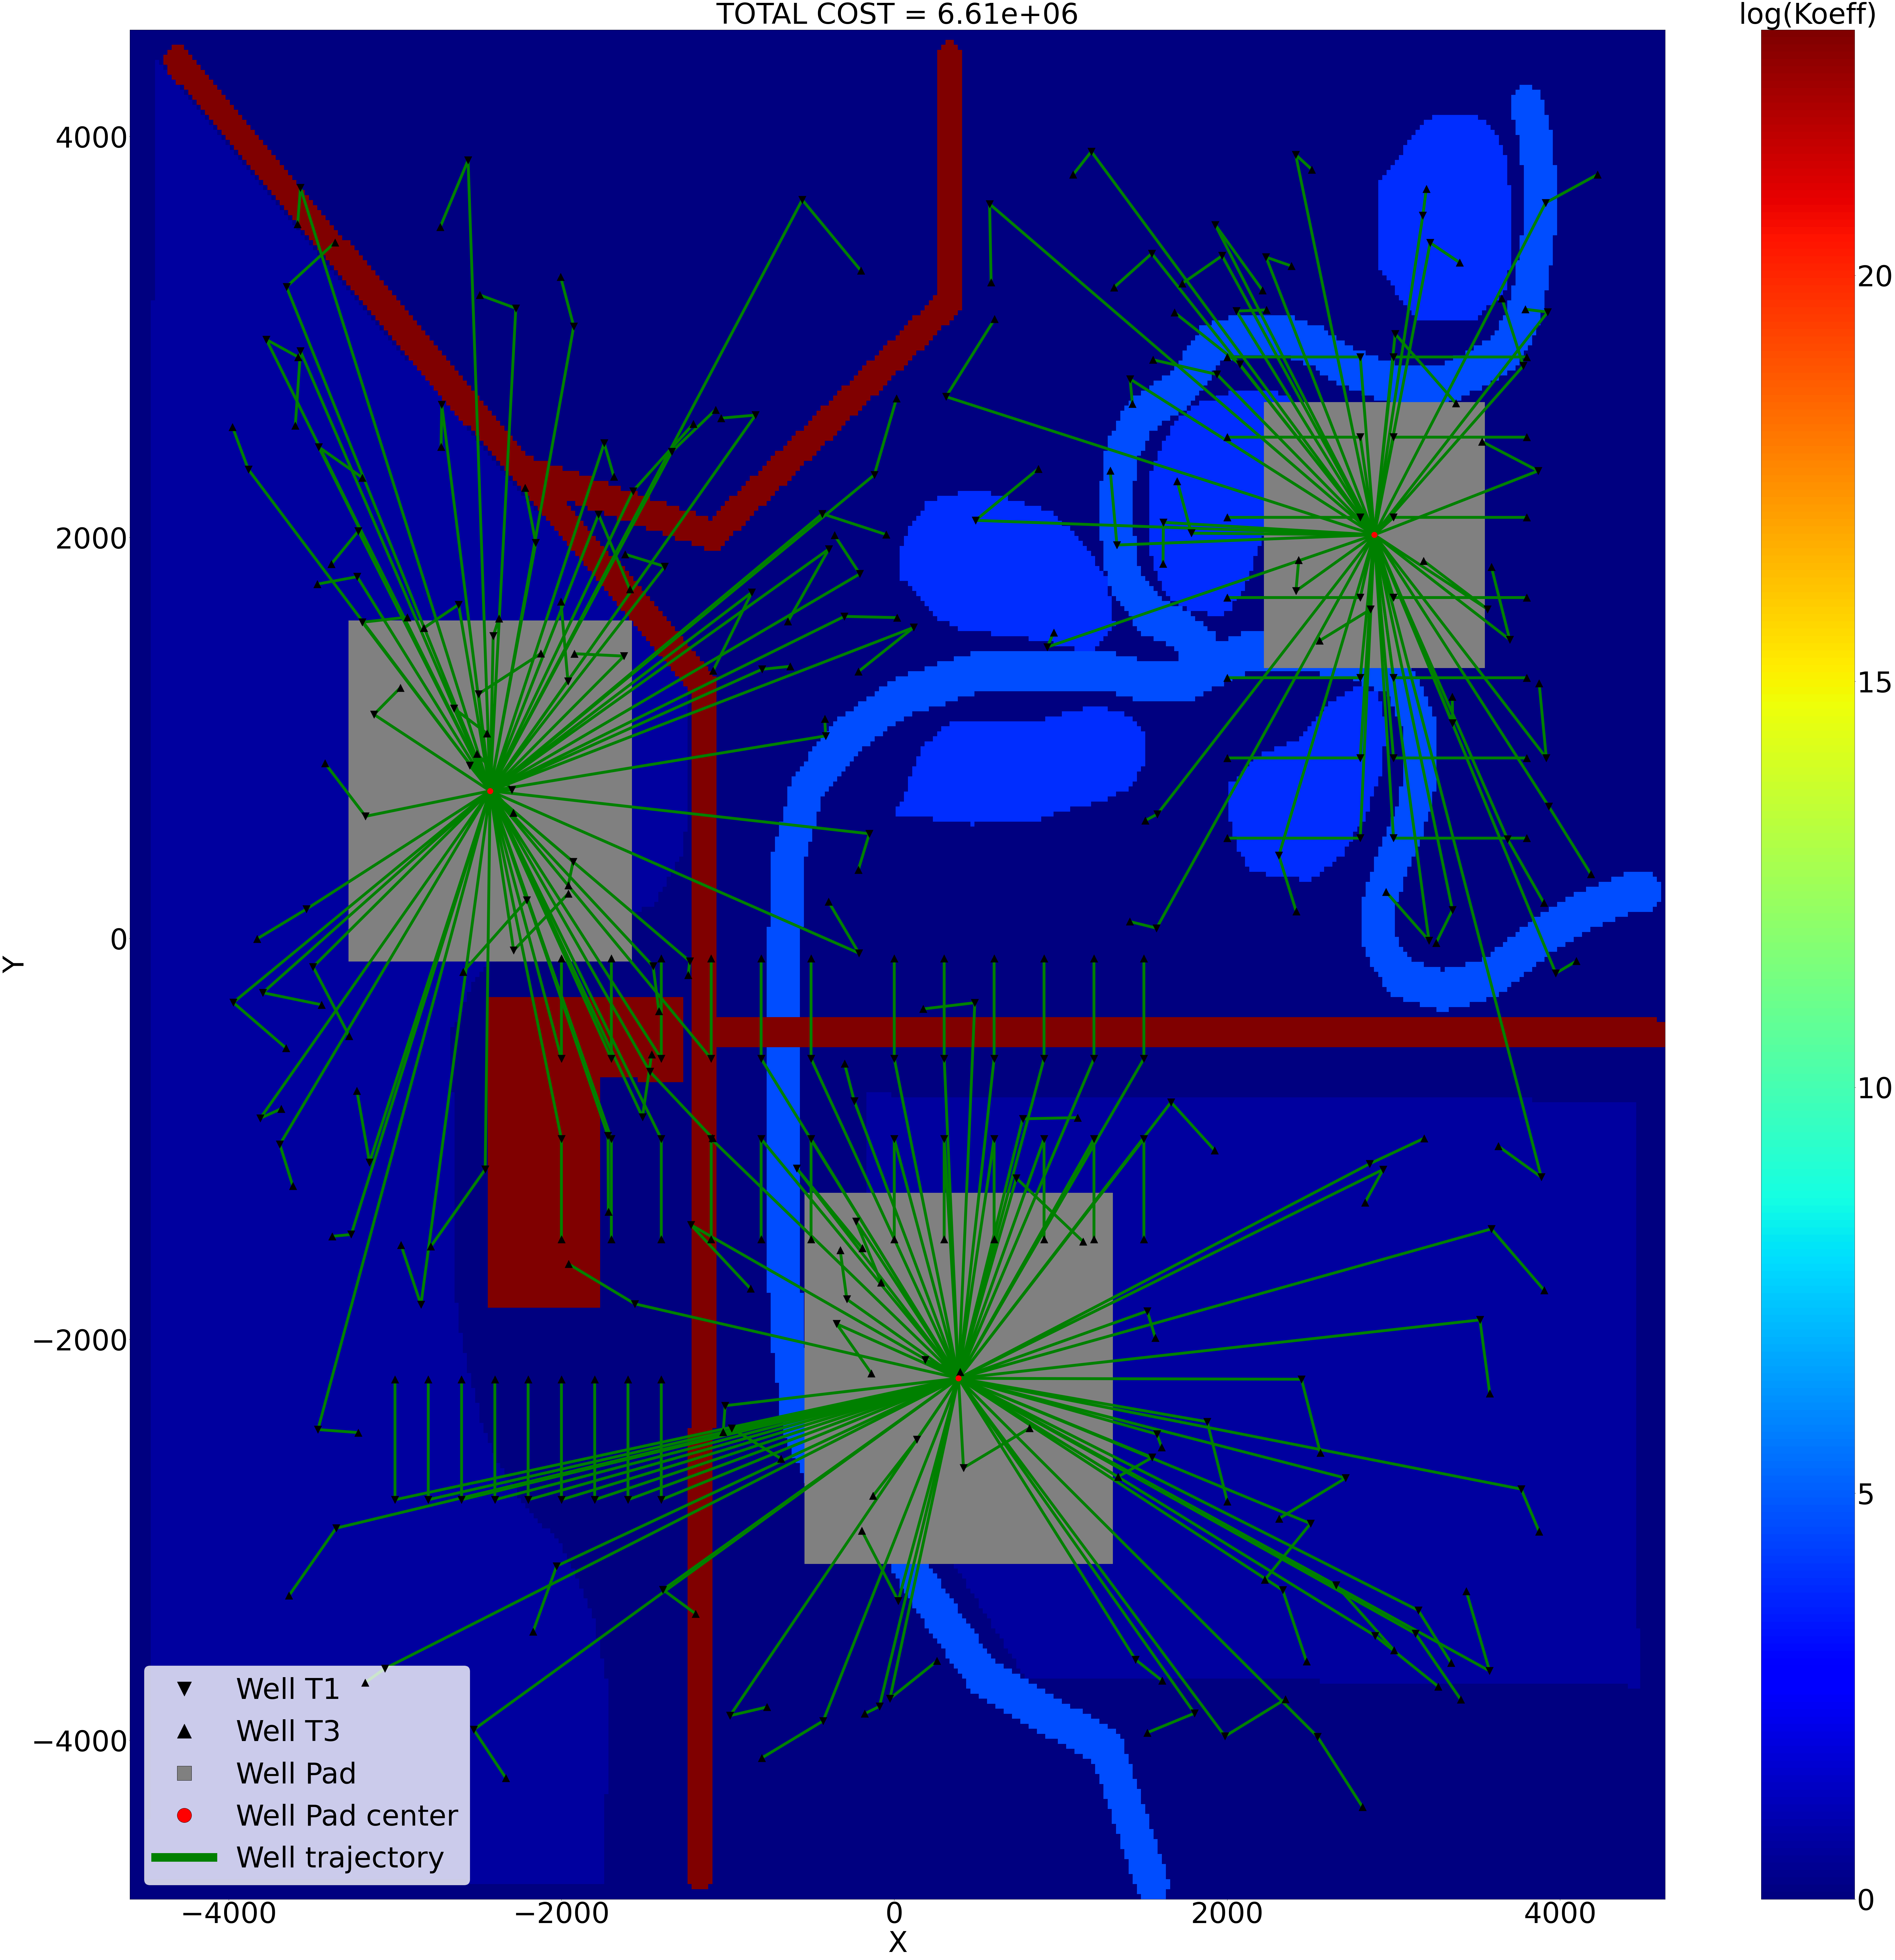

In [41]:
case2.solution.plot()